# Correcting Sanger Sequencing Chromatograms using Convolutional Neural Networks (CNNs)

## Authorship 

Harry Fong and Monther Alhamdoosh, CSL Research, Data Science, Bioinformatics & AI Group 


## Confientiality notice 

Not to be distributed within and outside CSL Limited, without consultation with the authors. 


## Background

This notebook will initially over-fit a small subset of training data to confirm
that a CNN can indeed learn to classify chromatograms using images. Following that,
we'll implement strategies to avoid overfitting. It is advised to install Anaconda Navigator. 

### System requirements
* tensorflow version 1.13 or above
* matplotlib
* numpy


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import gzip
import math
import pickle
import numpy as np

tf.enable_eager_execution()


# Data loading
This notebook should come with two other files, `train.pkl.gz` and `test.pkl.gz`,
in the same directory. Briefly, both files contain image data of size
`96 x 96 x 3`, representing `Height x Width x (RGB) Channels`. `train.pkl.gz` contains
`5000` while `test.pkl.gz` contains `1000` images and their corresponding labels.
There are 4 possible values for the labels, each representing a base:
* `0` = A
* `1` = C
* `2` = G
* `3` = T


In [2]:
label_mapping = {0: 'A', 1: 'C', 2: 'G', 3: 'T'}
with gzip.open("train.pkl.gz", "rb") as fp:
    train_data, train_labels = pickle.load(fp)
with gzip.open("test.pkl.gz", "rb") as fp:
    test_data, test_labels = pickle.load(fp)
    
print(f"Training data shape: {train_data.shape}")
print(f"Training labels: {train_labels.shape}")
print(f"Testing data shape: {test_data.shape}")
print(f"Testing labels: {test_labels.shape}")


Training data shape: (5000, 96, 96, 3)
Training labels: (5000,)
Testing data shape: (1000, 96, 96, 3)
Testing labels: (1000,)


# Data visualisation
Here, we'll define a helper function that will help visualise chromatograms.


In [3]:
def chromatogram(x, y, predicted=None):
    r"""
    Plots chromatograms with provided image `x` and label `y`.
    
    :param np.array x: array of shape (N, H, W, C)
    :param np.array y: array of shape (N,)
    :param np.array predicted: array of predictions, shaped (N,) (optional)
    :return: None
    """
    rows = int(np.sqrt(x.shape[0]))
    cols = math.ceil(x.shape[0] / rows)
    idx = 0
    legend_handles = [
        mpatches.Patch(color='green', label='A'),
        mpatches.Patch(color='blue', label='C'),
        mpatches.Patch(color='black', label='G'),
        mpatches.Patch(color='red', label='T')
    ]
    for i in range(rows):
        for j in range(cols):
            plt.subplot(rows, cols, idx + 1)
            plt.imshow(x[idx].astype(np.uint8))
            if predicted is not None:
                plt.xlabel(f"True: {label_mapping[y[idx]]}\nPredicted: {label_mapping[predicted[idx]]}")
            else:
                plt.xlabel(label_mapping[y[idx]])
            plt.xticks([])
            plt.yticks([])
            if idx == cols // 2 and i == 0:
                plt.legend(handles=legend_handles, loc="upper center",
                           bbox_to_anchor=(0.5, 1.5), ncol=4,
                           frameon=False)
            idx += 1
            if idx >= x.shape[0]:
                break
    plt.tight_layout()


A few training data examples:


In [4]:
chromatogram(train_data[:6], train_labels[:6])


You'll realise by now that the base to be predicted happens to be "centralised", i.e. it is
the *fifth* base in a window size of *nine* bases. Given that the peak widths vary, it's not
necessarily in the middle of the window.


# Data pre-processing

In most machine learning models, its not uncommon to normalise your input data (train, validation, test sets)
in order to keep the input values within a certain expected range.

In neural networks, data pre-processing affects the training phase of your model.
The backpropagation algorithm applies a series of multiplications (chain rule) to
update your weight parameters $W$; due to the multiplicative effect
of $x$ (input matrix) and $W$ (weight matrix), the gradients (for $W$)
flowing back from your loss function is multiplied by $x$,
your input matrix. Hence, the values of $x$ are typically normalised
to have $0$ mean and *unit* standard deviation to keep the gradients in control.

Other common normalisation methods involve decorrelating input features,
whitening, PCA reduction, etc. However, these are less common in image classification tasks.



### Splitting into train, validation, and test datasets

Here, we'll normalise our input data to have $0$ mean and $1$ standard deviation.

Note that it is a common pitfall to calculate the means and std. of your entire combined training, validation,
and test datasets; instead, the mean and std. should be calculated only on the training data. Therefore,
we'll first split our training dataset in to two parts: `train` and `validation` before calculating them.


In [5]:
# last 2000 examples will be allocated into the validation partition
val_data = train_data[3000:]
val_labels = train_labels[3000:]

# first 3000 examples will be retained as the training data
train_data = train_data[:3000]
train_labels = train_labels[:3000]

# while we're here, cast the data into float32
# since we'll be doing floating point arithmetic when training a NN
train_data = train_data.astype(dtype=np.float32)
val_data = val_data.astype(dtype=np.float32)
test_data = test_data.astype(dtype=np.float32)

# and cast the labels (which are values
# between 0-4 representing A, C, G, and T) into
# unsigned ints
train_labels = train_labels.astype(dtype=np.uint8)
val_labels = val_labels.astype(dtype=np.uint8)
train_labels = train_labels.astype(dtype=np.uint8)


Now, we have three partitions: `train`, `validation`, and `test`:


In [6]:
print(f"Training data shape: {train_data.shape}")
print(f"Training labels: {train_labels.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Validation labels: {val_labels.shape}")
print(f"Testing data shape: {test_data.shape}")
print(f"Testing labels: {test_labels.shape}")


Training data shape: (3000, 96, 96, 3)
Training labels: (3000,)
Validation data shape: (2000, 96, 96, 3)
Validation labels: (2000,)
Testing data shape: (1000, 96, 96, 3)
Testing labels: (1000,)


### Normalising data based on training mean and standard deviation
Calculate the mean and standard deviation on the `training` dataset, then
apply the normalisation on all `train`, `val`, and `test` datasets.


In [7]:
# per-pixel mean and standard dev.
mean = np.mean(train_data, axis=(0, 1, 2), dtype=np.float64)
std = np.std(train_data, axis=(0, 1, 2), dtype=np.float64)

train_data = (train_data - mean) / std
val_data = (val_data - mean) / std
test_data = (test_data - mean) / std

# Defining a simple convnet
Convolutional neural networks (*convnets*) are a popular choice for image classification tasks. It
has consistently topped the [ImageNet](http://www.image-net.org/) competition over other 
image classification methods. Here, we'll design a simple CNN to illustrate the concepts.

CNNs are typically composed of *convolutional layers* interleaved with *pooling layers*. The convolutional
layers are typically responsible for learning salient features of an image while the pooling layers
are used for downsampling. Images can also be downsampled by adjusting the strides of your convolutional
layers, thereby eliminating the need for pooling layers.

![](cnn.jpeg)

<small>
Image credit: https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53
</small>

In this section, we'll define a simple 3-layered CNN using `Keras`, a high level interface for deep learning
models.


In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1,
                           padding='same', activation='relu',
                           input_shape=(96, 96, 3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1,
                           padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=4, activation='softmax')
])


Instructions for updating:
Colocations handled automatically by placer.


### Convolutional layers
This model contains 3 convolutional layers:
```python
tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1,
                       padding='same', activation='relu'),
```
each with a filter(kernel) size of `3 x 3`, convolving over the image with a stride of `1`.
These filters contain numbers (*learnable* weights $W$) that will be fined-tuned during training
to search for salient features of input images. They will be multiplied element-wise with
your input image $x$ and "slides" to the next location in the image based on the stride value.
This animation shows the action of a `3 x 3` filter striding `1` unit at a time:

<div style="text-align:center"><img src ="stride.gif" /></div>
<small>Image credit: https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md</small>


The dotted boxes denote 0-padded entries in the image. This is necessary if the filter is to
centre the pixels at the edges when multiplying element-wise. This is specified as
`padding="same"`.

In the first convolutional layer, there are `16` filters.
We also apply the rectified linear unit activation function,
`ReLU` on the output of the element-wise multiplication (referred to as the *activation map*, the
entire green square in the diagram above).
Since there are `16` filters, the *activation maps* stack above each other, forming an
*activation volume*. The `shape` of an *activation volume* depends on the height and width, but the
depth (i.e. "channels") will now be `16` since we had `16` activation maps. This is depicted
in the CNN image above as the 3D block named `CONVOLUTION + RELU`.

The two subsequent convolution layers are similar except for the number of filters.
```python
# ... other layers
tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                       padding='same', activation='relu'),
# ... other layers
tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1,
                       padding='same', activation='relu'),
```
They are doubled as the activation map size is halved (via `MaxPooling`, see section below)
to preserve the time complexity per layer.
This CNN design is a simplified version of the VGG architecture<sup>1</sup>, a CNN that won
the ImageNet challenge in 2014.

### Pooling layers

The model interleaves each convolutional layer with a pooling layer to downsample the image
(or rather, the *activation map*) size.
```python
tf.keras.layers.MaxPool2D()
```
Similarly, it slides a filter across the image, but instead takes the maximum value of the activation map.
Since the `stride` is `2` by default, the activation map size is halved.

### Fully-connected, dense layer

The layer of this model is a fully connected layer. However, fully connected layers requires the
input data to be in two-dimensional (`N x D`); our activation volume has the shape `N x H x W x D` where `N` is 
the number of samples we trained on, `H` and `W` the height and width of the activation volume
(since there are three pooling layers, each halving the size,
the height and width will be $96 / 2^3 = 12$ by the time
we flatten it), and `D` the number of filters (number of activation **maps** stacked together)
we used in the previous convolutional layer.

```python
tf.keras.layers.Flatten()
tf.keras.layers.Dense(units=4, activation='softmax')
```

Intuitively, the `Flatten` operation concatenates the extra height `H`, width `W`, and
depth `D` dimensions into one dimension of size (`H` * `W` * `D`); the output size of this operation
is: `N x H` * `W` * `D`.

Given that we have four possible predictions: A, C, G, and T, the output units will be `4`.
Each unit gives a prediction "score". We can then normalise these scores so that they sum to one
using the *softmax* function. Then, our prediction will be based on the unit that contains the
highest (normalised) prediction score.


# Training and evaluation

## Compiling the model

The model will be compiled with an optimisation strategy, loss function, and a metric used to measure
the accuracy of our model.

#### Optimisers
The optimiser governs how the *learnable parameters* update themselves at each backpropagation iteration.
The most common optimiser is Stochastic Gradient Descent (SGD). SGD updates the learnable parameters
based on a learning rate (hyperparameter) which affects how quickly the network learns. Other more
advanced optimisers draw inspiration from (for example)
*momentum* (i.e. past updates affect the magnitude of the current update).
Besides SGD, the `Adam` optimiser is also a popular choice.


For this classification task, `Adam` trains the network much faster than
SGD, so we'll be using that instead. Like other hyperparameters,
this optimiser choice can only be found through the validation datasets and is problem
dependent.

#### Loss functions
Since this is a multi-class classification problem, the cross-entropy loss (or categorical
cross-entropy loss, or softmax loss) is commonly used to quantify how much "error" the network
currently has. Therefore, the goal of the *optimiser* is to minimise this value. Loss functions
are problem dependent.

#### Metrics
As with all machine learning models, precision, recall, and accuracy are the common measures of
performance. In this simple exercise, we'll concern ourselves with accuracy only.



In [9]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
__________

## Preparing the data for ingestion

For brevity, this example will be using the `from_tensor_slices` method which will not be sufficient
for large-scale datasets because of memory constraints. Nonetheless, `tf.data` offers other methods
that will work readily with large-scale datasets and is worth a read.


In [10]:
BATCH_SIZE = 128
train = (tf.data.Dataset.from_tensor_slices((train_data, train_labels))
         .repeat()                          # repeat dataset infinitely
         .batch(BATCH_SIZE))                # batch dataset to not overwhelm training
val = (tf.data.Dataset.from_tensor_slices((val_data, val_labels))
       .repeat()
       .batch(BATCH_SIZE))
test = (tf.data.Dataset.from_tensor_slices((test_data, test_labels))
        .batch(BATCH_SIZE))


## Training the model
We can now train the model based on the optimisation strategy, loss function, and training data.


`steps_per_epoch` lets the `fit` function know how many times to loop over our batches of 
size `BATCH_SIZE` (defined above) before **one** epoch is completed. An epoch is a complete
iteration over the entire training dataset.
 
Mini-batches are usually used rather than training the
whole dataset at once because it is computationally expensive to train on a large training dataset
and will adversely affect training (backpropagation will only update your weights after seeing
all your training data rather than after each mini-batch).


In [11]:
# floor division so that each datapoint is only visited once in each epoch
steps_per_epoch = train_data.shape[0] // BATCH_SIZE
validation_steps = val_data.shape[0] // BATCH_SIZE
history = model.fit(train,
                    epochs=10,
                    validation_data=val,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/10
23/23 [==============================] - 17s 719ms/step - loss: 1.4180 - acc: 0.3427 - val_loss: 1.2672 - val_acc: 0.4365
Epoch 2/10
23/23 [==============================] - 15s 661ms/step - loss: 1.1245 - acc: 0.5584 - val_loss: 0.9410 - val_acc: 0.5984
Epoch 3/10
23/23 [==============================] - 15s 638ms/step - loss: 0.6853 - acc: 0.7429 - val_loss: 0.5490 - val_acc: 0.7948
Epoch 4/10
23/23 [==============================] - 15s 640ms/step - loss: 0.4373 - acc: 0.8397 - val_loss: 0.4419 - val_acc: 0.8354
Epoch 5/10
23/23 [==============================] - 15s 638ms/step - loss: 0.3122 - acc: 0.8906 - val_loss: 0.4407 - val_acc: 0.8458
Epoch 6/10
23/23 [==============================] - 15s 632ms/step - loss: 0.2454 - acc: 0.9175 - val_loss: 0.3594 - val_acc: 0.8828
Epoch 7/10
23/23 [==============================] - 16s 695ms/step - loss: 0.1889 - acc: 0.9429 - val_loss: 0.3708 - val_acc: 0.8859
Epoch 8/10
23/23 [==============================] - 15s 634ms/step - 


The `history` object contains the losses and accuracy of our model across each epoch.
Ultimately, we care about the **validation** accuracy over the **training** accuracy.
This guides our search for the optimal *hyperparameters*.

Moreover, the **validation**
dataset contains examples where our model *did not* train on. This gives a representation
of how our model will perform on untrained(unseen) data (i.e. when this model is in production).


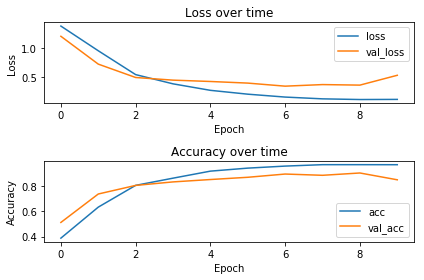

In [13]:
losses = [i for i in history.history.keys() if i.endswith("loss")]
accs = [i for i in history.history.keys() if i.endswith("acc")]

plt.subplot(211)
for loss in losses:
    plt.plot(history.history[loss], label=loss)
plt.title("Loss over time")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.subplot(212)
plt.title("Accuracy over time")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
for acc in accs:
    plt.plot(history.history[acc], label=acc)
plt.legend()
plt.tight_layout()


# Visualising misclassified chromatograms

The model above should yield around 90% accuracy on the training and 80% on the validation dataset.
This section visualises the mistakes that the model made on the validation dataset.


In [14]:
# grab a handful of data
small_val_data, small_val_label = val_data[:BATCH_SIZE], val_labels[:BATCH_SIZE]

# make prediction based on trained model
prediction = np.argmax(model.predict(small_val_data), axis=1)

# grab the wrong predictions
incorrect_predictions = prediction[prediction != small_val_label]

# get the incorrect predictions' images
diagrams = small_val_data[prediction != small_val_label] * std + mean

# get the true labels
true_labels = small_val_label[prediction != small_val_label]

# plot!
chromatogram(diagrams[:6], true_labels[:6], incorrect_predictions[:6])


# Overfitting

From the plot above, the validation accuracy falls behind our training accuracy.
This occurred due to the lack of regularizers -- our model is overfitting the training
data (i.e. blindly memorising the training data).

**Regularizers** penalises the model for overfitting the data. Common regularizers include:
* Dropout (and its variants, e.g. DropConnect, SpatialDropout etc.)
* L2 norm


# Defining a better convnet

To generalise the model defined before, the code chunk below adds L2 regularizer
to the weights of the fully connected layer.

Intuitively, it penalises the learnable weights for "over-memorising" the training data
and encourages the weights to generalise. Mathematically, this is accomplished by
adding the magnitude of the squared of the weight matrix scaled by a constant factor: $\lambda|W^2|$ 
to the loss function. The constant factor $\lambda$ is a hyperparameter.


In [ ]:
# regularization factor
w2_lambda = 0.43529044748517515 # was 0.01
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1,
                           padding='same', activation='relu',
                           input_shape=(96, 96, 3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1,
                           padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=4, activation='softmax',
                          kernel_regularizer=tf.keras.regularizers.l2(w2_lambda))
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(train,
                    epochs=10,
                    validation_data=val,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)


In [ ]:
losses = [i for i in history.history.keys() if i.endswith("loss")]
accs = [i for i in history.history.keys() if i.endswith("acc")]

plt.subplot(211)
for loss in losses:
    plt.plot(history.history[loss], label=loss)
plt.title("Loss over time")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.subplot(212)
plt.title("Accuracy over time")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
for acc in accs:
    plt.plot(history.history[acc], label=acc)
plt.legend()
plt.tight_layout()


The loss and accuracy graphs should now show lesser difference between training and validation, albeit with a lower
overall accuracy. This can be remedied with more training epochs.


## Evaluation

The final measure of a model's performance is conducted on unseen data, the `test` dataset.
Unlike the `validation` dataset, it does not influence the model's choice of hyperparameters
and is therefore closest to the "unseen" data that the model will be exposed to when in production.


In [ ]:
test_loss, test_accuracy = model.evaluate(test, steps=(test_data.shape[0] // BATCH_SIZE))
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")


## Defining an even better model

Throughout this notebook, the hyperparameters:
* learning rate
* number of hidden layers
* number of filters
* optimiser
* regularization strength $\lambda$

where chosen for you. In a typical setting, they should be cross-validated using the validation
dataset, and the hyperparameters should be chosen according to the best performance shown
in the validation dataset.

Here is a rough outline of a grid search, a common strategy used to find hyperparameters:


In [ ]:
learning_rates = [1e-3, 1e-3, 1e-1]
filters = [32, 16, 64]
w2_lambda = [0.25, 0.1, 0.05]

for lr in learning_rates:
    for filts in filters:
        for w2_reg in w2_lambda:
            model = tf.keras.Sequential([
                tf.keras.layers.Conv2D(filters=filts, kernel_size=3, strides=1,
                                       padding='same', activation='relu',
                                       input_shape=(96, 96, 3)),
                tf.keras.layers.MaxPool2D(),
                tf.keras.layers.Conv2D(filters=filts * 2, kernel_size=3, strides=1,
                                       padding='same', activation='relu'),
                tf.keras.layers.MaxPool2D(),
                # TODO: ... and more layers
            ])
            model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])
            
            # ################################### 
            #           Train the model         #
            #####################################
            # TODO: fit the model
            # history = model.fit(...)
            
            # ################################### 
            #          Evaluate the model       #
            #####################################
            # TODO: evaluate the model on validation set
            # loss, acc = model.evaluate(...)
            
            # ################################### 
            #            Save the model         #
            #####################################
            # TODO: save the hyperparameters in this iteration if
            #        the acc of the validation set
            #        is higher than what we've seen so far
            

# Conclusion
There are many more topics not covered in this short example. Below are a few commonly used
techniques that are worth a read.

## Regularization
We used L2 norm as the regularizer in this notebook. There are plenty of other techniques that are commonly used:
* Image augmentation
* Dropout, DropConnect, SpatialDropout
* L1 norm, L2 norm
* etc.

## Batch Normalisation
**Almost always want this for deeper networks.** Batch normalisation normalises the output
values of each layer to improve training in deeper networks. Essentially, this uses the same
idea of normalising our input data $x$ but applies this to *every* layer of the network.

## Weight initialisation
Along with batch normalisation, weight initialisation can affect the performance of a network,
especially during the training phase.
Batch normalisation allows this initialisation to be a bit more lax.

## Hyperparameter optimisation
This exercise did not optimise them using the validation dataset. Typically, the hyperparameters:
* learning rate
* number of hidden layers
* number of hidden units
* dropout rate
* optimiser
* regularizer
* etc.

should be tuned based on the performance of the model on the validation data. Common strategies
include grid search or random search.

## Pretrained models

The simple model used in this exercise was inspired by VGG nets<sup>1</sup>.
It is common to use pre-trained and pre-crafted models such as VGG net, ResNet, etc. in
image classification tasks as they are well designed and trained on large quantities of training data.
The concept of transfer learning allows these models to be adapted into related image
classification tasks with minimal model training and can save a significant amount of time.

See [Keras' pretrained models](https://keras.io/applications/).


[1] K. Simonyan and A. Zisserman. Very deep convolutional networks
for large-scale image recognition. In ICLR, 2015

